## Overview
This notebook downloads earthquake data (USGS catalog) and plots earthquake magnitudes vs. epicentral distance.
It requires several python packages, at least:

1. numpy
1. matplotlib
1. cartopy

In [1]:
# Download earthquake catalog data

import numpy as np
import os
import urllib.request
import shutil
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

lusi_coord = (-7.526469, 112.711131) # lat,lon
lusi_lon = lusi_coord[1]
lusi_lat = lusi_coord[0]

data_site    = "https://earthquake.usgs.gov/fdsnws/event/1/query.csv"
text_query = "?starttime=1976-01-01%2000:00:00&endtime=2006-05-28%2023:59:59&latitude=-7.526469&longitude=112.711131&maxradiuskm=1500&minmagnitude=4.0&eventtype=earthquake&orderby=time"
url = data_site + text_query
print("The URL request will be:")
print(url)

The URL request will be:
https://earthquake.usgs.gov/fdsnws/event/1/query.csv?starttime=1976-01-01%2000:00:00&endtime=2006-05-28%2023:59:59&latitude=-7.526469&longitude=112.711131&maxradiuskm=1500&minmagnitude=4.0&eventtype=earthquake&orderby=time


In [2]:
outputFilename = "EQ_Catalog.txt"
os.remove(outputFilename)
with urllib.request.urlopen(url) as response, open(outputFilename, 'wb') as outputFile:
        shutil.copyfileobj(response, outputFile)
outputFile.close()

# Check that the file was downloaded
if os.path.isfile(outputFilename):
    print("File '{}' downloaded OK".format(outputFilename))
else:
    print("Error downloading '{}' ".format(outputFilename))

File 'EQ_Catalog.txt' downloaded OK


In [3]:
# Parse earthquake catalog file
eqfile = open(outputFilename)
header=None
eq_lat = []
eq_lon = []
eq_depth = []
eq_mag = []
eq_time_str = []
eq_time = []
for line in eqfile:
    if header is None:
        header=line
        field_names = header.split(',')
        time_field = field_names.index('time')
        lat_field = field_names.index('latitude')        
        lon_field = field_names.index('longitude')
        mag_field = field_names.index('mag')
        depth_field = field_names.index('depth')
    else:
        fields = line.split(',')
        eq_time_str.append(fields[time_field])
        eq_time.append( np.datetime64(fields[time_field],tz='UTC') )
        eq_lat.append(float(fields[lat_field]))
        eq_lon.append(float(fields[lon_field]))
        eq_mag.append(float(fields[mag_field]))
        eq_depth.append(float(fields[depth_field]))
eqfile.close()

eq_lat = np.array(eq_lat)
eq_lon = np.array(eq_lon)
eq_mag = np.array(eq_mag)
eq_depth = np.array(eq_depth)
eq_time = np.array(eq_time, dtype='datetime64')

/Users/max/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


In [4]:
# Identify yogyakarta earthquake within catalog
yogyakarta_index = eq_time_str.index('2006-05-26T22:53:58.920Z')
print(yogyakarta_index)

4


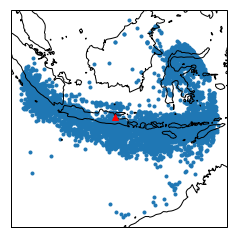

In [5]:
# Make a map of the earthquake positions

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(eq_lon,eq_lat,marker='.',transform=ccrs.PlateCarree())
plt.plot(lusi_lon,lusi_lat,'r^',transform=ccrs.PlateCarree())

ax.coastlines(resolution='50m', color='black', linewidth=1)
plt.show()

In [6]:
# Load catalogs of other triggered phenomena
triggered_eq_m,triggered_eq_dist = np.loadtxt('data/EQ.dat',usecols=(0,1),unpack=True)
geyser_m,geyser_dist = np.loadtxt('data/geyser.dat',usecols=(0,1),unpack=True)
stream_m,stream_dist = np.genfromtxt('data/stream_all.dat',dtype=float,usecols=(0,1),unpack=True)
hot_m,hot_dist = np.loadtxt('data/hot.dat',usecols=(0,1),unpack=True)
liq_m,liq_dist = np.loadtxt('data/liq_all.dat',usecols=(0,1),unpack=True)
volc_m,volc_dist = np.loadtxt('data/volc_lemarchand.dat',usecols=(0,1),unpack=True)
well_m,well_dist = np.loadtxt('data/well.dat',usecols=(0,1),unpack=True)

# Load the catalog of triggered mud volcano eruptions from csv file (exported from excel spreadsheet)
mv_filename = 'MV_Summary_Table.csv'
mv_file = open(mv_filename,'r')
import csv
header = None
mv_mag = []
mv_dist = []
mv_mv = []
for line in csv.reader(mv_file, quotechar='"', delimiter=',',quoting=csv.QUOTE_ALL, skipinitialspace=True):
    if header is None:
        header = line
        mv_field = header.index('MV')
        mag_field = header.index('Magnitude')
        dist_field = header.index('Dist (km)')
    else:
        mv_mv.append(line[mv_field])
        mv_mag.append(float(line[mag_field]))
        mv_dist.append(float(line[dist_field]))

# merge all of these into a single list for plotting, with symbols
# [mag,dist,shape,edge color,face color,legend,size]
catalog = [[well_m,well_dist,'s','b','w','wells',8],
           [triggered_eq_m,triggered_eq_dist,'s','k','w','earthquake',8],
           [stream_m,stream_dist,'o','b','none','streams',8],           
           [liq_m,liq_dist,'o','g','w','liquefaction',8],
           [volc_m,volc_dist,'^','r','w','magmatic volcanoes',9],
           [mv_mag,mv_dist,'^','brown','brown','mud volcanoes',10]]
#,[geyser_m,geyser_dist,'o','r','w','geyser']] # geyser plots out of visible range

In [7]:
# Calculate epicentral distances using cartopy
import cartopy.geodesic as gd
globe = gd.Geodesic()
eq_dist_m = []
for lon, lat in zip(eq_lon, eq_lat):
    this_dist = globe.inverse([lusi_lon,lusi_lat],[lon,lat])[0][0]
    eq_dist_m.append(this_dist)
eq_dist_m = np.array(eq_dist_m)
eq_dist_km = eq_dist_m/1000.
# Calculate hypocentral distance, using a planar approximation in the vertical direction
eq_hyp_dist = np.sqrt( eq_dist_km**2 + eq_depth**2 )

In [8]:
# Calculate the Wang (2007) energy density curve
wang_mag = np.linspace(4,10,10)
def wang_r(M,e):
    """Returns distance given magnitude and seismic energy density
    using Wang and Manga (2010) seismic energy density formula"""
    return 10.0**(0.48*M - 0.33*np.log10(e)-1.4)

def wang_e(M,r):
    """Wang and Manga (2010) seismic energy density"""
    return 10.0**(1./0.33*(0.48*M-np.log10(r)-1.4))

# verify that the two above equations are consistent
assert( np.isclose( wang_r(6.0,wang_e(6.0,200.0)),200.0 ) )
assert( np.isclose( wang_r(3.0,wang_e(3.0,100.0)),100.0 ) )

def brumm_pga(M,r):
    """Davies et el. 2008 empirical relation for PGA
    Takes magnitude, r in km"""
    c1 = 11.2
    c2 = 1.5
    c3 = -5.26
    c4 = 0.00575
    return np.exp(c1+c2*M+c3*np.log(r)+c4*r )
def brumm_pgv(M,r):
    """Davies et el. 2008 empirical relation for PGV
    Takes magnitude, r in km"""
    c1 = 4.67
    c2 = 2.04
    c3 = -4.53
    c4 = 0.00478
    return np.exp(c1+c2*M+c3*np.log(r)+c4*r )
    
def wc_rupture(M):
    """Wells and Coppersmith (1994) empirical rupture length scaling"""
    a = -2.44;
    b = 0.59;
    return 10.**(a+b*M)

yog_e = wang_e(eq_mag[yogyakarta_index],eq_hyp_dist[yogyakarta_index])
yog_pgv = brumm_pgv(eq_mag[yogyakarta_index],eq_hyp_dist[yogyakarta_index])
yog_pga = brumm_pga(eq_mag[yogyakarta_index],eq_hyp_dist[yogyakarta_index])
yog_mag = eq_mag[yogyakarta_index]
yog_dist = eq_hyp_dist[yogyakarta_index]

In [9]:
print('Yogyakarts distance = ',yog_dist,' km, M=',yog_mag)

Yogyakarts distance =  254.754238864  km, M= 6.3


In [10]:
# Calculate the seismic energy density for each triggered MV eruption in the catalog.
mv_ed = []
for i in range(len(mv_mag)):
    mv_ed.append(wang_e(mv_mag[i],mv_dist[i]))
mv_ed = np.array(mv_ed)
idx = np.argsort(mv_ed)
mv_min_e = mv_ed[idx[0]]
print( mv_min_e )
# Display a table with seismic energy density for each event
table = "| Mud Volcano | Mag | Dist (km) | Energy Density |\n"
table += "|---|---|---|---|\n"
for i in idx:
    table += "|" + mv_mv[i] + "|" + str(mv_mag[i]) + "|" + '{:.0f}'.format(mv_dist[i]) + "|" + '{:1.2e}'.format(mv_ed[i]) + "|\n"
display(Markdown(table))

0.0185458057197


| Mud Volcano | Mag | Dist (km) | Energy Density |
|---|---|---|---|
|South Semau|7.0|340|1.85e-02|
|Gobi Altay, Mongolia|5.8|90|1.87e-02|
|Salton Sea|4.4|19|1.92e-02|
|S.Maria in Paganico, Italy|5.5|64|1.94e-02|
|Montegibbio|5.94|87|3.31e-02|
|Paterno, Italy|5.2|34|4.79e-02|
|Kandewari, Pakistan|7.7|482|6.72e-02|
|Marazy, AZ|4.6|15|7.67e-02|
|Torre, Italy|6.1|77|8.20e-02|
|Regnano, Italy|5.0|21|1.06e-01|
|Caltanizetta, Italy|5.9|56|1.10e-01|
|Makran Coast, Pakistan|7.7|383|1.35e-01|
|Regnano, Italy|5.9|52|1.38e-01|
|Casola-Querzola, Italy|5.9|52|1.38e-01|
|Regnano, Italy|6.1|63|1.51e-01|
|Casola-Querzola, Italy|6.1|63|1.51e-01|
|Shikhzairli, AZ|5.7|40|1.56e-01|
|Ospitaletto, Italy|5.9|49|1.65e-01|
|Paterno, Italy|5.7|39|1.69e-01|
|Puianello, Italy|6.1|55|2.27e-01|
|S.Maria in Paganico, Italy|6.0|48|2.42e-01|
|Nirano, Italy|6.1|52|2.69e-01|
|La Croce, Italy|6.0|45|3.00e-01|
|Case tedeschi 2 bis, Italy|6.0|45|3.05e-01|
|Baratang, Andaman Islands|9.1|1030|7.31e-01|
|Kalamaddyn, AZ|5.7|24|7.35e-01|
|Montegibbio|5.09|12|7.78e-01|
|Niikappu|7.8|226|9.32e-01|
|Niikappu|7.6|153|1.56e+00|
|Salton Sea|7.2|97|1.64e+00|
|S. Maria in Paganico, Italy|6.5|43|1.77e+00|
|Monteleone 1, Italy|6.5|41|2.12e+00|
|Monteleone 2, Italy|6.5|41|2.12e+00|
|Valle Corvone, Italy|6.5|41|2.12e+00|
|Monteleone 3, Italy|6.5|41|2.13e+00|
|La Croce, Italy|6.5|41|2.15e+00|
|Case Tedeschi 1, Italy|6.5|41|2.16e+00|
|Case Tedeschi 3, Italy|6.5|41|2.17e+00|
|Contrada S. Salvatore 1, Italy|6.5|38|2.72e+00|
|Contrada S. Salvatore 3, Italy|6.5|38|2.72e+00|
|Contrada S. Salvatore 2, Italy|6.5|38|2.73e+00|
|Nirano, Italy|5.7|15|3.05e+00|
|Montegibbio|5.7|14|3.38e+00|
|Beciu, Romania|7.4|92|3.72e+00|
|Bozakhtarma, AZ|6.9|51|4.16e+00|
|Hingol, Makran|8.1|189|4.38e+00|
|Kumano Knoll #5, Japan|7.4|80|5.68e+00|
|Shikhzairli, AZ|6.9|45|6.08e+00|
|Niikappu|8.2|186|6.42e+00|
|Gwadar, Makran|8.1|155|7.98e+00|
|Livanoca, South Caspaun|8.2|141|1.49e+01|
|Portico di Romagna, Italy|5.0|4|1.49e+01|
|Niikappu|6.7|25|1.85e+01|
|Niikappu|8.3|145|1.91e+01|
|Thok, Baluchistan|7.7|61|3.53e+01|
|Leikunghuo, Taiwan|6.8|18|6.99e+01|
|Gobi Altay, Mongolia|8.3|75|1.41e+02|
|Luoshang, Taiwan|6.8|10|4.15e+02|
|Ormara, Makran|8.1|41|4.49e+02|
|Niikappu|8.6|58|8.37e+02|


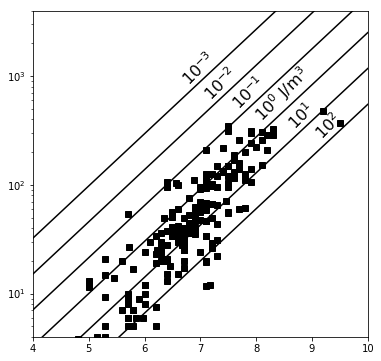

In [11]:
# Reproduce Wang (2007) Figure 1
f,ax = plt.subplots(1,1,figsize=(6,6))
rot=45
ax.plot(wang_mag,wang_r(wang_mag,1e-3) ,'k')
ax.text(6.6,1.35*wang_r(6.6,1e-3),'$10^{-3}$',fontsize=16,rotation=rot,horizontalalignment='left',verticalalignment='bottom')
ax.plot(wang_mag,wang_r(wang_mag,1e-2) ,'k')
ax.text(7.0,1.35*wang_r(7.0,1e-2),'$10^{-2}$',fontsize=16,rotation=rot,horizontalalignment='left',verticalalignment='bottom')
ax.plot(wang_mag,wang_r(wang_mag,1e-1) ,'k')
ax.text(7.5,1.35*wang_r(7.5,1e-1),'$10^{-1}$',fontsize=16,rotation=rot,horizontalalignment='left',verticalalignment='bottom')
ax.plot(wang_mag,wang_r(wang_mag,1e0)  ,'k')
ax.text(7.9,1.4*wang_r(7.9,1e0),'$10^{0}$ J/m$^3$',fontsize=16,rotation=rot,horizontalalignment='left',verticalalignment='bottom')
ax.plot(wang_mag,wang_r(wang_mag,1e1)  ,'k')
ax.text(8.5,1.35*wang_r(8.5,1e1),'$10^{1}$',fontsize=16,rotation=rot,horizontalalignment='left',verticalalignment='bottom')
ax.plot(wang_mag,wang_r(wang_mag,1e2)  ,'k')
ax.text(9.,1.35*wang_r(9.,1e2),'$10^{2}$',fontsize=16,rotation=rot,horizontalalignment='left',verticalalignment='bottom')
ax.plot(liq_m,liq_dist,'ks')
ax.set_yscale('log')
ax.set_xlim((4,10))
ax.set_ylim((4,4000))
plt.show()

0.00426515770582


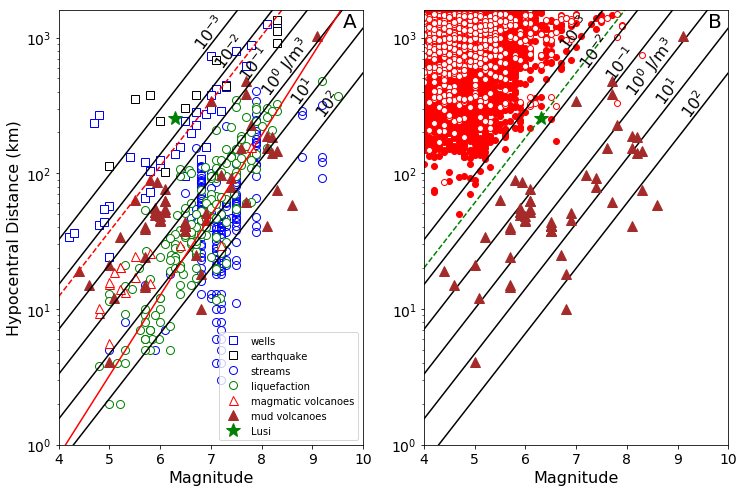

In [18]:
# calculate approximate hypocentral distance
minimum_depth = 30.
eq_e  = wang_e(eq_mag, eq_hyp_dist)
yog_e = eq_e[yogyakarta_index]
print(yog_e)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))
# plot all triggered phenomena
for entry in catalog:
    ax1.plot(entry[0],entry[1],marker=entry[2],markeredgecolor=entry[3],markerfacecolor=entry[4],label=entry[5],linestyle='none',markersize=entry[6])


ax1.set_yscale('log')

# Plot historic seismicity with mud volcanoes only
ax2.plot(eq_mag[eq_depth > minimum_depth], eq_hyp_dist[eq_depth > minimum_depth],'ro')
ax2.plot(eq_mag[eq_depth <= minimum_depth],eq_hyp_dist[eq_depth <= minimum_depth],linestyle='none',marker='o',markerfacecolor='w',markeredgecolor='r')

# seismic energy density lines
from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_weight('heavy')
for ax in (ax1,ax2):
    ax.plot(eq_mag[yogyakarta_index],eq_hyp_dist[yogyakarta_index],'g*',markersize=14,label='Lusi')

    ax.plot(wang_mag,wang_r(wang_mag,1e-3) ,'k')
    rot = 53
    ax.text(6.6,1.35*wang_r(6.6,1e-3),'$10^{-3}$',fontsize=16,rotation=rot,horizontalalignment='left',verticalalignment='bottom')
    ax.plot(wang_mag,wang_r(wang_mag,1e-2) ,'k')
    ax.text(7.0,1.35*wang_r(7.0,1e-2),'$10^{-2}$',fontsize=16,rotation=rot,horizontalalignment='left',verticalalignment='bottom')
    ax.plot(wang_mag,wang_r(wang_mag,1e-1) ,'k')
    ax.text(7.5,1.35*wang_r(7.5,1e-1),'$10^{-1}$',fontsize=16,rotation=rot,horizontalalignment='left',verticalalignment='bottom')
    ax.plot(wang_mag,wang_r(wang_mag,1e0)  ,'k')
    ax.text(7.9,1.4*wang_r(7.9,1e0),'$10^{0}$ J/m$^3$',fontsize=16,rotation=rot,horizontalalignment='left',verticalalignment='bottom')
    ax.plot(wang_mag,wang_r(wang_mag,1e1)  ,'k')
    ax.text(8.5,1.35*wang_r(8.5,1e1),'$10^{1}$',fontsize=16,rotation=rot,horizontalalignment='left',verticalalignment='bottom')
    ax.plot(wang_mag,wang_r(wang_mag,1e2)  ,'k')
    ax.text(9.,1.35*wang_r(9.,1e2),'$10^{2}$',fontsize=16,rotation=rot,horizontalalignment='left',verticalalignment='bottom')

    ax.set_yscale('log')
    ax.set_xlim([4, 10])
ax1.text(9.6,1.2e3,'A',fontsize=20)
ax2.text(9.6,1.2e3,'B',fontsize=20)
ax1.plot(wang_mag,wang_r(wang_mag,mv_min_e),'r--')
ax1.plot(wang_mag,wc_rupture(wang_mag),'r')
ax1.legend()    
ax2.plot(mv_mag,mv_dist,marker='^',markerfacecolor='brown',markeredgecolor='brown',linestyle='none',markersize=10)
ax2.plot(wang_mag,wang_r(wang_mag,yog_e),'g--') # lusi seismic energy density    
ax1.set_ylim([1,1600])
ax2.set_ylim([1,1600])
fs=16
ax2.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlabel('Magnitude',fontsize=fs)
ax1.set_xlabel('Magnitude',fontsize=fs)
ax1.set_ylabel('Hypocentral Distance (km)',fontsize=fs)
#plt.title('Magnitude-distance-triggering')
plt.savefig('magnitude-distance.eps')
plt.savefig('magnitude-distance.png')
plt.show()

In [13]:
# Calculate the Wang (2007) seismic energy density for every event in the catalog.
# Same as previous, except approximate HYPO-central distance
eq_e   = wang_e(   eq_mag, eq_hyp_dist)
eq_pga = brumm_pga(eq_mag, eq_hyp_dist)
eq_pgv = brumm_pgv(eq_mag, eq_hyp_dist)
yog_e = eq_e[yogyakarta_index]

print('Events of all depths with seismic energy density equal or greater than Yogyakarta')
print('yogyakarta energy density ',yog_e)
table = "| Time | Mag | Depth (km) | Epicenter Dist. (km) | Hypocenter Dist. (km) | Lat | Lon | ED (J/m$^3$) | PGA (m/s$^2$) | PGV (m/s) |\n"
table = table + "|---|---|---|---|---|---|---|---|---|---|---|---|\n"
for i in range(len(eq_e)):
    if eq_e[i] >= yog_e:
        table += "|" + str(eq_time[i])    + '|' + str(eq_mag[i]) + '|'+ str(eq_depth[i]) \
               + '|' + '{:.2f}'.format(eq_dist_km[i]) + '|' + '{:.2f}'.format(eq_hyp_dist[i]) + '|' + str(eq_lat[i]) + '|' + str(eq_lon[i])  \
               + '|' + '{:1.2e}'.format(eq_e[i]) + '|' + '{:1.2e}'.format(eq_pga[i]) + '|' + '{:1.2e}'.format(eq_pgv[i]) + '|\n'
display(Markdown(table))

Events of all depths with seismic energy density equal or greater than Yogyakarta
yogyakarta energy density  0.00426515770582


| Time | Mag | Depth (km) | Epicenter Dist. (km) | Hypocenter Dist. (km) | Lat | Lon | ED (J/m$^3$) | PGA (m/s$^2$) | PGV (m/s) |
|---|---|---|---|---|---|---|---|---|---|---|---|
|2006-05-26T22:53:58.920|6.3|12.5|254.45|254.75|-7.961|110.446|4.27e-03|8.87e-04|1.73e-03|
|2000-06-04T16:28:26.170|7.9|33.0|1216.07|1216.52|-4.721|102.087|7.94e-03|6.62e-04|3.78e-03|
|1998-09-28T13:34:30.490|6.6|151.6|80.82|171.80|-8.194|112.413|3.84e-02|6.86e-03|1.28e-02|
|1996-06-17T11:22:18.540|7.9|587.3|1091.49|1239.47|-7.137|122.589|7.50e-03|6.84e-04|3.87e-03|
|1996-01-01T08:05:10.830|7.9|24.0|1214.88|1215.12|0.729|119.931|7.96e-03|6.60e-04|3.77e-03|
|1994-06-03T21:06:59.880|6.6|25.9|314.24|315.31|-10.362|112.892|6.10e-03|6.42e-04|1.62e-03|
|1994-06-02T18:17:34.020|7.8|18.4|326.62|327.14|-10.477|112.835|3.04e-01|3.43e-03|1.68e-02|
|1992-12-12T05:29:26.350|7.8|27.7|1018.01|1018.38|-8.48|121.896|9.73e-03|4.64e-04|2.67e-03|
|1977-08-19T06:08:55.000|8.3|25.0|741.11|741.53|-11.164|118.378|1.36e-01|1.06e-03|8.30e-03|
|1976-07-14T07:13:24.000|6.5|40.0|250.40|253.57|-8.17|114.888|8.45e-03|1.22e-03|2.65e-03|


In [14]:
# Calculate the Wang (2007) seismic energy density for every event in the catalog.
# Same as previous, except approximate HYPO-central distance
eq_e   = wang_e(   eq_mag, eq_hyp_dist)
eq_pga = brumm_pga(eq_mag, eq_hyp_dist)
eq_pgv = brumm_pgv(eq_mag, eq_hyp_dist)
yog_e = eq_e[yogyakarta_index]
yog_pga = eq_pga[yogyakarta_index]
yog_pgv = eq_pgv[yogyakarta_index]

print('Events of all depths with seismic energy density equal or greater than Yogyakarta')
print('yogyakarta energy density ',yog_e)
table = "| Time | Mag | Depth (km) | Epicenter Dist. (km) | Hypocenter Dist. (km) | Lat | Lon | ED (J/m$^3$) | PGA (m/s$^2$) | PGV (m/s) |\n"
table = table + "|---|---|---|---|---|---|---|---|---|---|---|---|\n"
n=0
for i in range(len(eq_e)):
    if eq_e[i] >= yog_e or eq_pgv[i] >= yog_pgv or eq_pga[i] >= yog_pga:
        table += "|" + str(eq_time[i])    + '|' + str(eq_mag[i]) + '|'+ str(eq_depth[i]) \
               + '|' + '{:.2f}'.format(eq_dist_km[i]) + '|' + '{:.2f}'.format(eq_hyp_dist[i]) + '|' + str(eq_lat[i]) + '|' + str(eq_lon[i])  \
               + '|' + '{:1.2e}'.format(eq_e[i]) + '|' + '{:1.2e}'.format(eq_pga[i]) + '|' + '{:1.2e}'.format(eq_pgv[i]) + '|\n'
        n+=1
display(Markdown(table))
print(n)

Events of all depths with seismic energy density equal or greater than Yogyakarta
yogyakarta energy density  0.00426515770582


| Time | Mag | Depth (km) | Epicenter Dist. (km) | Hypocenter Dist. (km) | Lat | Lon | ED (J/m$^3$) | PGA (m/s$^2$) | PGV (m/s) |
|---|---|---|---|---|---|---|---|---|---|---|---|
|2006-05-26T22:53:58.920|6.3|12.5|254.45|254.75|-7.961|110.446|4.27e-03|8.87e-04|1.73e-03|
|2005-11-18T16:45:08.780|4.8|64.4|122.95|138.79|-8.51|113.231|1.77e-04|1.17e-03|7.31e-04|
|2005-07-14T05:50:25.260|4.5|54.7|87.41|103.11|-8.067|112.133|1.59e-04|2.90e-03|1.28e-03|
|2005-06-11T13:18:51.180|5.4|60.0|164.55|175.15|-8.923|112.196|6.52e-04|1.04e-03|1.03e-03|
|2004-11-11T21:26:41.150|7.5|10.0|1342.46|1342.50|-8.152|124.868|1.54e-03|4.46e-04|1.95e-03|
|2004-10-30T09:55:33.010|4.9|81.4|118.48|143.75|-8.589|112.574|2.22e-04|1.16e-03|7.83e-04|
|2004-07-17T01:20:33.390|5.1|53.8|132.91|143.39|-6.519|113.367|4.37e-04|1.59e-03|1.19e-03|
|2004-04-17T02:20:32.890|4.4|10.0|85.86|86.44|-8.298|112.798|1.94e-04|5.74e-03|2.15e-03|
|2004-01-25T09:45:55.350|5.2|115.5|86.98|144.59|-7.994|112.077|5.96e-04|1.78e-03|1.41e-03|
|2003-09-16T16:41:15.720|5.0|91.3|122.81|153.03|-7.962|111.687|2.57e-04|1.03e-03|7.56e-04|
|2003-07-19T21:20:37.010|5.9|56.2|207.58|215.05|-8.682|111.227|1.87e-03|9.45e-04|1.37e-03|
|2003-05-28T01:34:02.080|5.2|65.3|118.51|135.31|-8.577|112.499|7.29e-04|2.39e-03|1.82e-03|
|2003-05-23T09:48:29.410|4.5|33.0|80.63|87.13|-7.772|112.023|2.65e-04|6.43e-03|2.55e-03|
|2002-08-26T17:36:44.700|5.6|33.0|146.53|150.20|-6.398|113.406|2.03e-03|2.74e-03|2.76e-03|
|2002-06-21T05:07:11.930|5.1|42.2|144.72|150.75|-6.416|113.404|3.76e-04|1.27e-03|9.82e-04|
|2001-10-19T03:28:44.460|7.5|33.0|1296.29|1296.71|-4.102|123.907|1.71e-03|4.12e-04|1.83e-03|
|2001-08-07T03:22:35.890|5.6|90.5|172.12|194.46|-8.61|113.832|9.27e-04|9.09e-04|1.06e-03|
|2001-05-02T15:11:16.270|4.8|78.0|108.77|133.85|-8.487|112.499|1.97e-04|1.38e-03|8.41e-04|
|2001-01-14T19:51:26.360|5.2|74.1|104.58|128.17|-8.469|112.635|8.59e-04|3.05e-03|2.25e-03|
|2000-06-04T16:28:26.170|7.9|33.0|1216.07|1216.52|-4.721|102.087|7.94e-03|6.62e-04|3.78e-03|
|2000-05-07T19:21:52.040|4.9|48.6|51.78|71.01|-7.985|112.806|1.88e-03|3.13e-02|1.35e-02|
|2000-05-04T04:21:16.210|7.6|26.0|1398.74|1398.98|-1.105|123.573|1.90e-03|5.78e-04|2.60e-03|
|2000-02-12T03:11:02.690|5.3|107.9|133.17|171.40|-8.701|112.445|4.98e-04|9.86e-04|9.11e-04|
|1999-08-18T19:36:51.620|4.8|33.0|89.34|95.24|-8.31|112.514|5.53e-04|6.61e-03|3.27e-03|
|1998-11-29T14:10:31.960|7.7|33.0|1479.21|1479.58|-2.071|124.891|2.24e-03|7.94e-04|3.64e-03|
|1998-09-28T13:34:30.490|6.6|151.6|80.82|171.80|-8.194|112.413|3.84e-02|6.86e-03|1.28e-02|
|1997-07-14T12:54:46.570|4.2|33.0|107.55|112.50|-6.78|112.087|4.48e-05|1.24e-03|4.91e-04|
|1996-12-17T21:59:35.030|4.8|71.5|109.69|130.94|-8.508|112.568|2.11e-04|1.52e-03|9.17e-04|
|1996-06-17T11:22:18.540|7.9|587.3|1091.49|1239.47|-7.137|122.589|7.50e-03|6.84e-04|3.87e-03|
|1996-01-06T16:34:04.000|4.2|63.2|35.52|72.50|-7.798|112.883|1.70e-04|9.91e-03|2.97e-03|
|1996-01-01T08:05:10.830|7.9|24.0|1214.88|1215.12|0.729|119.931|7.96e-03|6.60e-04|3.77e-03|
|1995-07-04T16:48:31.240|4.2|63.5|41.39|75.80|-7.802|112.965|1.48e-04|7.99e-03|2.46e-03|
|1994-06-03T21:06:59.880|6.6|25.9|314.24|315.31|-10.362|112.892|6.10e-03|6.42e-04|1.62e-03|
|1994-06-02T18:17:34.020|7.8|18.4|326.62|327.14|-10.477|112.835|3.04e-01|3.43e-03|1.68e-02|
|1993-05-25T00:42:25.400|4.9|93.0|89.01|128.73|-8.288|112.45|3.10e-04|1.91e-03|1.20e-03|
|1992-12-12T05:29:26.350|7.8|27.7|1018.01|1018.38|-8.48|121.896|9.73e-03|4.64e-04|2.67e-03|
|1992-09-04T22:48:10.750|4.9|33.0|112.38|117.12|-8.522|112.507|4.13e-04|2.93e-03|1.74e-03|
|1992-09-04T00:56:14.990|4.9|33.0|144.48|148.20|-8.79|112.378|2.03e-04|1.02e-03|6.97e-04|
|1992-07-05T06:00:51.370|5.1|33.0|160.05|163.41|-7.671|111.268|2.94e-04|8.97e-04|7.24e-04|
|1992-06-26T02:36:13.460|5.2|63.9|140.35|154.21|-8.79|112.593|4.90e-04|1.34e-03|1.10e-03|
|1992-06-09T00:31:56.310|6.1|63.9|206.22|215.90|-8.474|111.1|3.60e-03|1.26e-03|2.03e-03|
|1992-05-14T18:19:11.160|4.7|33.0|37.54|49.98|-7.376|113.016|2.79e-03|1.30e-01|3.98e-02|
|1991-06-20T05:18:52.510|7.5|31.4|1477.21|1477.54|1.196|122.787|1.15e-03|5.86e-04|2.41e-03|
|1990-04-18T13:39:19.010|7.8|25.7|1482.38|1482.61|1.186|122.857|3.12e-03|9.29e-04|4.48e-03|
|1989-12-28T17:12:48.030|4.9|33.0|86.68|92.74|-6.786|112.454|8.38e-04|8.71e-03|4.47e-03|
|1989-10-25T06:46:42.710|5.0|41.4|72.28|83.30|-7.151|113.247|1.62e-03|1.69e-02|8.52e-03|
|1989-04-17T14:20:31.140|5.1|112.8|75.89|135.95|-8.179|112.924|5.14e-04|2.02e-03|1.46e-03|
|1988-07-14T23:18:08.090|5.3|33.0|106.99|111.96|-8.487|112.596|1.81e-03|6.58e-03|4.72e-03|
|1988-04-04T16:12:25.290|5.9|60.9|204.02|212.91|-9.364|112.874|1.92e-03|9.84e-04|1.41e-03|
|1986-05-12T10:35:00.420|5.1|33.0|98.20|103.60|-6.969|112.019|1.17e-03|6.99e-03|4.29e-03|
|1984-07-27T00:11:34.910|4.7|33.0|88.01|93.99|-7.26|111.96|4.12e-04|6.06e-03|2.81e-03|
|1981-07-06T00:00:39.250|5.0|121.4|61.58|136.13|-8.077|112.795|3.66e-04|1.72e-03|1.19e-03|
|1980-12-24T23:55:06.400|5.6|63.0|174.39|185.42|-8.955|112.041|1.07e-03|1.11e-03|1.26e-03|
|1980-08-13T00:17:48.900|5.0|33.0|82.35|88.71|-7.874|112.051|1.34e-03|1.25e-02|6.57e-03|
|1980-03-31T13:14:46.600|5.2|49.0|153.62|161.25|-8.89|112.977|4.28e-04|1.10e-03|9.33e-04|
|1979-05-15T01:06:12.900|5.0|81.0|125.87|149.68|-8.163|111.765|2.75e-04|1.13e-03|8.23e-04|
|1978-10-14T18:41:13.700|5.6|184.0|55.08|192.07|-7.464|112.216|9.63e-04|9.57e-04|1.11e-03|
|1977-08-19T06:08:55.000|8.3|25.0|741.11|741.53|-11.164|118.378|1.36e-01|1.06e-03|8.30e-03|
|1976-07-14T07:13:24.000|6.5|40.0|250.40|253.57|-8.17|114.888|8.45e-03|1.22e-03|2.65e-03|
|1976-05-08T05:31:37.400|4.8|91.0|96.81|132.87|-8.394|112.594|2.02e-04|1.42e-03|8.66e-04|


60


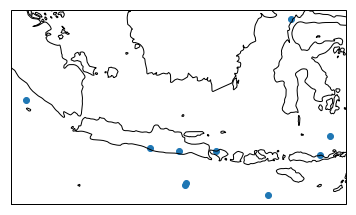

In [15]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
mask = eq_e >= yog_e
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(eq_lon[mask],eq_lat[mask],marker='o',transform=ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
plt.show()

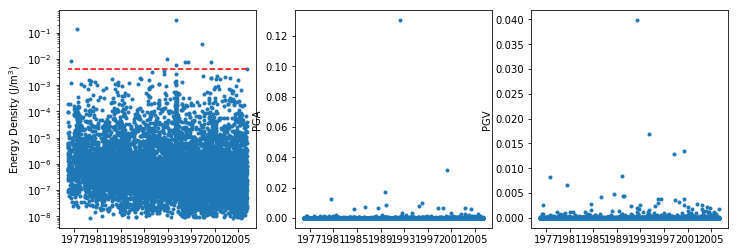

In [16]:
from datetime import datetime


import matplotlib.dates as mdates
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
#ax1.xaxis_date()
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
t=eq_time.astype(datetime)
ax1.plot_date(t,eq_e,'.')
ax1.plot_date([t[0], t[-1]],[yog_e, yog_e],'r--')
ax1.set_yscale('log')
#f.autofmt_xdate()
#ax1.xaxis_date()
ax1.set_ylabel('Energy Density (J/m$^3$)')
ax2.plot_date(t,eq_pga,'.')
ax2.set_ylabel('PGA')
ax3.plot_date(t,eq_pgv,'.')
ax3.set_ylabel('PGV')
plt.show()

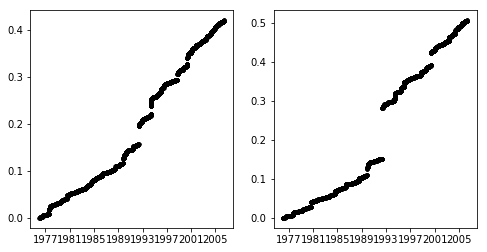

In [17]:
#cumulative pga, pgv plots
cpga = np.zeros(eq_pga.shape)
cpga[-1] = eq_pga[-1]
cpgv = np.zeros(eq_pgv.shape)
cpgv[-1] = eq_pgv[-1]
for i in reversed(range(0,len(eq_pga)-1)):
    cpga[i] = cpga[i+1] + eq_pga[i]
    cpgv[i] = cpgv[i+1] + eq_pgv[i]

f, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))
ax1.plot(t,cpgv,'k.')
ax2.plot(t,cpga,'k.')
plt.show()